In [464]:
p = 0.0844
import numpy as np
import torch
from scipy.stats import binom
import networkx as nx
import matplotlib.pyplot as plt
import os
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

In [465]:
prob = np.load('src/node_dist.npy')

In [466]:
node_dist =  torch.distributions.Categorical(torch.tensor(prob))
# sample 1 value
n = node_dist.sample()
print(n)

tensor(102)


<BarContainer object of 188 artists>

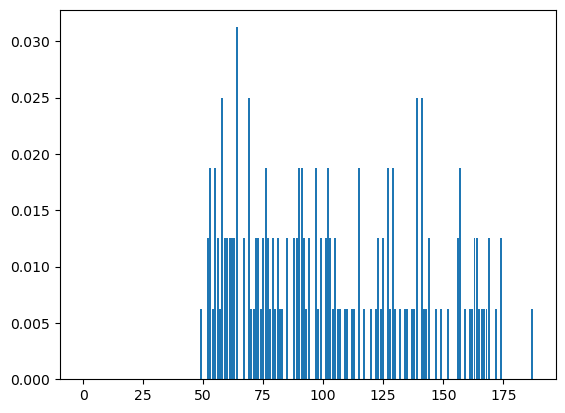

In [467]:
# draw distribution
import matplotlib.pyplot as plt
indices = torch.arange(len(prob))
plt.bar(indices, prob)

In [468]:
def ciphertext_from_message(message, key=None, nonce=None, n = None):
    if key is None:
        key = os.urandom(32)
    if nonce is None:
        nonce = os.urandom(16)

    if isinstance(key, str):
        key = bytes.fromhex(key)
    if isinstance(nonce, str):
        nonce = bytes.fromhex(nonce)
    if n is None:
        n = node_dist.sample()
    bytes_length = n // 8
    
    # cut message to if it's too long
    if len(message) > bytes_length:
        message = message[:bytes_length]
    

    message_bytes = message.encode() + b'\0' * (bytes_length - len(message.encode()))
    cipher = Cipher(algorithms.ChaCha20(key, nonce), mode=None, backend=default_backend())
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(message_bytes) + encryptor.finalize()
    ciphertext_bits = np.unpackbits(np.frombuffer(ciphertext, dtype=np.uint8))
  #  print(ciphertext_bits)
    bit_to_randomize = n - len(ciphertext_bits)
    assert bit_to_randomize >= 0 and bit_to_randomize < 8
    ciphertext_bits = np.concatenate([ciphertext_bits, np.random.randint(0, 2, (bit_to_randomize,))])
    assert len(ciphertext_bits) == n
    return ciphertext_bits, key, nonce


c1,k,n = ciphertext_from_message("A")
c2,_,_ = ciphertext_from_message("A", k, n, len(c1))
usefull_bits = (len(c1) // 8) * 8
assert np.sum(np.abs(c1[:usefull_bits] - c2[:usefull_bits])) == 0

In [469]:
def binom_pesudo_sampler(ciphertext_bits , p):
    n = len(ciphertext_bits)
    rv = binom(n-2, p)
    samples = []
    for i in range(n):
        u = (ciphertext_bits[i] + np.random.uniform(0, 1))/2
        assert u >= 0 and u <= 1
        samples.append(rv.ppf(u))
    return samples

In [470]:
def ER_pesudo_sampler(ciphertext_bits, p):
    n = len(ciphertext_bits)
    
    offset_dist = binom(1, p)
    while 1:
        d = binom_pesudo_sampler(ciphertext_bits, p)    
        offset = offset_dist.rvs()
        degrees = [d[i] + offset for i in range(n)]
        if sum(degrees) % 2 == 0:
            while 1:
                try:
                #    print(degrees)
                    G = nx.random_degree_sequence_graph(degrees)
                    degrees_from_graph = [G.degree(node) for node in G.nodes()]
                    assert degrees == degrees_from_graph
                    return G, offset
                except nx.exception.NetworkXError:
                    print('no graph')
                    
c,k,n = ciphertext_from_message("A")
G,offset = ER_pesudo_sampler(c, p)

In [471]:

"""
degree_assortativity_coefficients = []
Es = []
for i in range(1000):
    G = ER_pesudo_sampler(n, p)
    r = nx.degree_assortativity_coefficient(G)
    degree_assortativity_coefficients.append(r)
    Es.append(sum([G.degree(node) for node in G.nodes()]))
print(np.mean(degree_assortativity_coefficients), np.var(degree_assortativity_coefficients))
theoretical_var_e = 2*(n-1)*n*p*(1-p)
theoretical_mean_e = n * (n-1) * p
print(np.mean(Es), theoretical_mean_e)
print(np.var(Es), theoretical_var_e)
"""

'\ndegree_assortativity_coefficients = []\nEs = []\nfor i in range(1000):\n    G = ER_pesudo_sampler(n, p)\n    r = nx.degree_assortativity_coefficient(G)\n    degree_assortativity_coefficients.append(r)\n    Es.append(sum([G.degree(node) for node in G.nodes()]))\nprint(np.mean(degree_assortativity_coefficients), np.var(degree_assortativity_coefficients))\ntheoretical_var_e = 2*(n-1)*n*p*(1-p)\ntheoretical_mean_e = n * (n-1) * p\nprint(np.mean(Es), theoretical_mean_e)\nprint(np.var(Es), theoretical_var_e)\n'

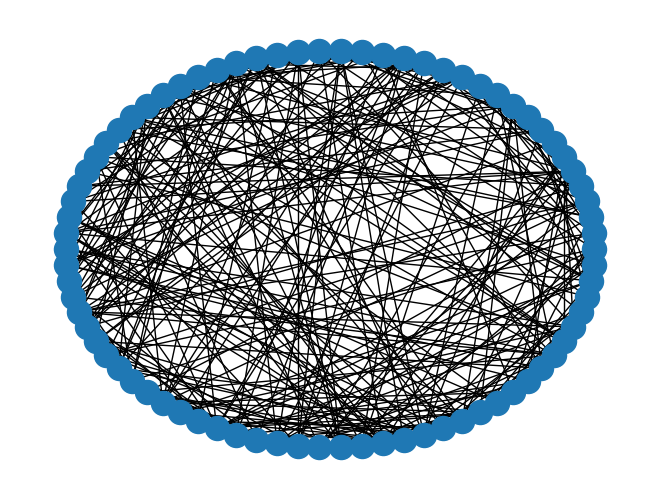

In [473]:
def watermark_embedding(message, key=None, nonce=None):
    c,k,n = ciphertext_from_message(message, key, nonce)
    G,offset = ER_pesudo_sampler(c, p)
    return G, k, n, offset

G,_,_,_ = watermark_embedding("A")
# plot graph
pos = nx.circular_layout(G)
nx.draw(G, pos)

In [530]:
# get G's adjacency matrix
A = nx.to_numpy_array(G)
print(A)

[[0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [525]:
def watermark_detection(G, offset, key, nonce, message):

    n = len(G.nodes())
    ciphertext_bits_true ,_,_ = ciphertext_from_message(message, key, nonce, n)
    rv = binom(n-2, p)
    degrees = [G.degree(node) -offset for node in G.nodes()]
    ciphertext_bits_recovered = []
    for i in range(n):
        u = rv.cdf(degrees[i])
        if u <=0.5:
            ciphertext_bits_recovered.append(0)
        else:
            ciphertext_bits_recovered.append(1)
    assert len(ciphertext_bits_true) == len(ciphertext_bits_recovered)
    usefull_bits = (n // 8) * 8
    ciphertext_bits_true = ciphertext_bits_true[:usefull_bits]
    ciphertext_bits_recovered = ciphertext_bits_recovered[:usefull_bits]
    return np.sum(np.abs(ciphertext_bits_true - ciphertext_bits_recovered)) / usefull_bits

In [526]:
message = "A"
errs = []
for i in range(5000):
    G, key, nonce, offset = watermark_embedding(message)
    errs.append( watermark_detection(G, offset, key, nonce, message))
print("mean error rate", np.mean(errs), "variance error rate", np.var(errs))

mean error rate 0.08930043384333244 variance error rate 0.004719999696021756


In [ ]:
"""
simulation_time = 100000
err_time = 0
for i in range(simulation_time):
    degrees = degree_dist.rvs(n)
    while sum(degrees) % 2 != 0:
        degrees = degree_dist.rvs(n)
    try:
        G = nx.havel_hakimi_graph(degrees)
    except nx.exception.NetworkXError:
        err_time += 1
        
print(err_time/simulation_time)
"""

In [ ]:
# generate ER random graph
rv = binom(n-2, p)
rv_offset = binom(1,p)
degrees = []

degrees2 = []

for i in range(10000):
    G = nx.binomial_graph(n, p)
    degrees.append(sum([G.degree(node) for node in G.nodes()]))
    y = rv.rvs(n)
    z = rv_offset.rvs()
    f = [y[i] + z for i in range(n)]
    while sum(f) % 2 != 0:
        y = rv.rvs(n)
        f = [y[i] + z for i in range(n)]
    degrees2.append(sum(f))
#histogram
plt.hist(degrees, bins=range(350, 600, 1))
plt.hist(degrees2, bins=range(350, 600, 1))

# print var and mean
print(np.var(degrees), np.mean(degrees))
print(np.var(degrees2), np.mean(degrees2))
# legend
plt.legend(['ER', 'degree distribution'])

In [ ]:
2*(n-1)*n*p*(1-p)

In [ ]:
n * (n-1) * p

In [ ]:
nn = 10000
rv = binom(nn-1, p)
rds = rv.rvs(nn)
while sum(degrees) % 2 != 0:
    degrees = rv.rvs(nn)
G = nx.binomial_graph(nn, p)
gds = [G.degree(node) for node in G.nodes()]


print(np.var(rds), np.mean(rds))
print(np.var(gds), np.mean(gds))

In [ ]:
plt.hist(rds, bins=range(600, 1000, 1))
plt.hist(gds, bins=range(600, 1000, 1))

In [ ]:
rv_x = binom(n-2, p)
rv_z = binom(1,p)
Y = []

for i in range(10000):
    y = rv_x.rvs(n)
    z = rv_z.rvs()
    f = [y[i] + z for i in range(n)]
    Y.append(sum(f))
    
print(np.var(Y), np.mean(Y))